## G10 FX Strategy

In [1]:
import pandas as pd
import numpy as np
from operator import sub
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import seaborn

### import data and set parameters

In [2]:
Data_sheet=pd.read_csv("fair_price.csv",index_col=0)
pairs=[('EUR', 'GBP'), ('GBP', 'JPY'), ('GBP', 'DKK'), ('JPY', 'AUD'), ('JPY', 'NZD'),
       ('JPY', 'CAD'), ('JPY', 'CHF'), ('JPY', 'NOK'), ('JPY', 'SEK'), ('JPY', 'DKK'),
       ('AUD', 'SEK'), ('CAD', 'CHF'), ('CAD', 'NOK'), ('CAD', 'SEK'), ('CHF', 'NOK'),
       ('CHF', 'SEK'), ('CHF', 'DKK')]
namelist = ['EUR','GBP','JPY','AUD','NZD','CAD','CHF','NOK','SEK','DKK']
base = Data_sheet['GBP']
N = len(base)
TRANS_FEE=0.0002

In [3]:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'

### heatmap for co-integration

In [4]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = list(data[keys[i]].values)
            S2 = list(data[keys[j]].values)
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.10:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

scores, pvalues, pairs = find_cointegrated_pairs(Data_sheet)

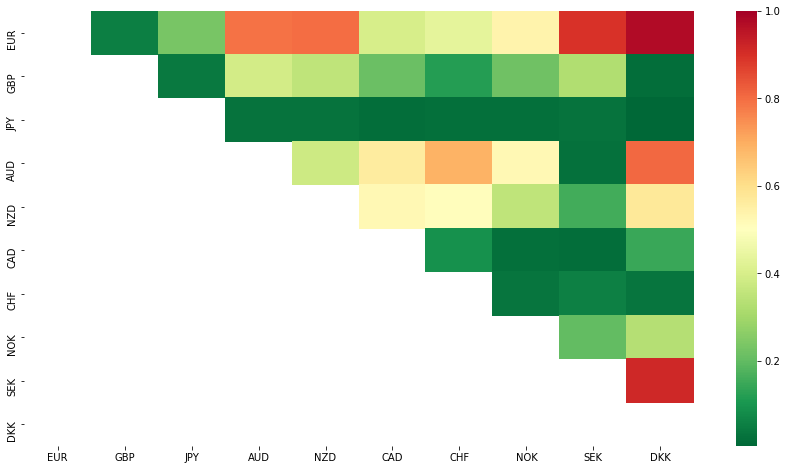

In [5]:
seaborn.heatmap(pvalues, xticklabels=namelist,
                yticklabels=namelist, cmap='RdYlGn_r',
                mask = (pvalues >= 0.98))
plt.show()

### pair trade

In [6]:
def trade(S1, S2, indexS1, indexS2, window1, window2):
    MAX_HOLD = 5 # maximum position

    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std
    
    money = [0] * len(ratios)
    value = [0] * len(ratios)
    countS1 = 0
    countS2 = 0
    sig = [[0] * 10 for _ in range(len(ratios))]  # log the operation signal.
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1 and countS1 > -MAX_HOLD:
                countS1 -= 1
                countS2 += ratios[i]
                sig[i][indexS1] = -1
                sig[i][indexS2] = ratios[i]
                money[i]-=S1[i]*TRANS_FEE*1+abs(ratios[i])*S2[i]*TRANS_FEE  # long 1 short 1, 2 transaction fees
        # Buy long if the z-score is < 1
        elif zscore[i] < -1 and countS1 < MAX_HOLD:
                countS1 += 1
                countS2 -= ratios[i]
                sig[i][indexS1] = 1
                sig[i][indexS2] = -ratios[i]
                money[i]-=S1[i]*TRANS_FEE*1+abs(ratios[i])*S2[i]*TRANS_FEE # long 1 short 1, 2 transaction fees
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money[i] += countS1 * S1[i] + countS2 * S2[i]
            money[i] -= abs(countS1 * S1[i]) * TRANS_FEE + abs(countS2 * S2[i]) * TRANS_FEE
            sig[i][indexS1] = -countS1
            sig[i][indexS2] = -countS2
            countS1 = 0
            countS2 = 0
        # when it comes to the end, clear the position.
        if i == len(S1)-1:
            money[i] += countS1 * S1[i] + countS2 * S2[i]
            money[i] -= abs(countS1 * S1[i])*TRANS_FEE+abs(countS2 * S2[i])*TRANS_FEE
            sig[i][indexS1] = -countS1
            sig[i][indexS2] = -countS2
            countS1 = 0
            countS2 = 0

        value[i] = countS1 * S1[i] + countS2 * S2[i]

    money = np.array(money)
    money = np.cumsum(money) # money we earn
    value = np.array(value)
    value = money + value
    value = pd.Series(value, index=ratios.index)
    sig = pd.DataFrame(sig,index = S1.index,columns=namelist)

    return value, sig

D:\anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


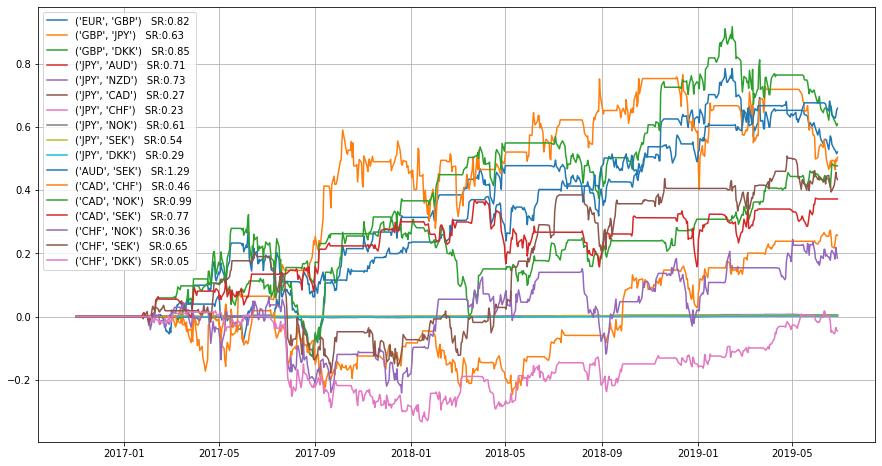

In [7]:
pnl_series=[]
sharpe_series={}
pairs_pnl=[0]*N
signal = pd.DataFrame([[0]*10 for _ in range(N)],index=base.index,columns=namelist)

# polt the whole pairs
for i in range(len(pairs)):
    indexS1 = namelist.index(pairs[i][0])
    indexS2 = namelist.index(pairs[i][1])
    pnl,temp = trade(Data_sheet[pairs[i][0]].iloc[:N],
                     Data_sheet[pairs[i][1]].iloc[:N],indexS1,indexS2,5, 60)
    signal += temp
    pairs_pnl=list(map(lambda x,y:x+y,pnl,pairs_pnl))
    pnl.index = pd.to_datetime(pnl.index)

#     return_pnl = pnl.diff(1)/pnl
    return_pnl = np.array((pnl+1).diff(1)[1:])/np.array((pnl[:-1]+1))
    sharpe_ratio = return_pnl.mean()/return_pnl.std()*np.sqrt(252)
    pnl_series.append(return_pnl)
    sharpe_series[pairs[i]]=sharpe_ratio
#     pnl.plot(label=pairs[i])
    plt.plot(pnl,label=str(pairs[i])+'   SR:'+str(round(sharpe_ratio,2)))

plt.legend()
plt.show()

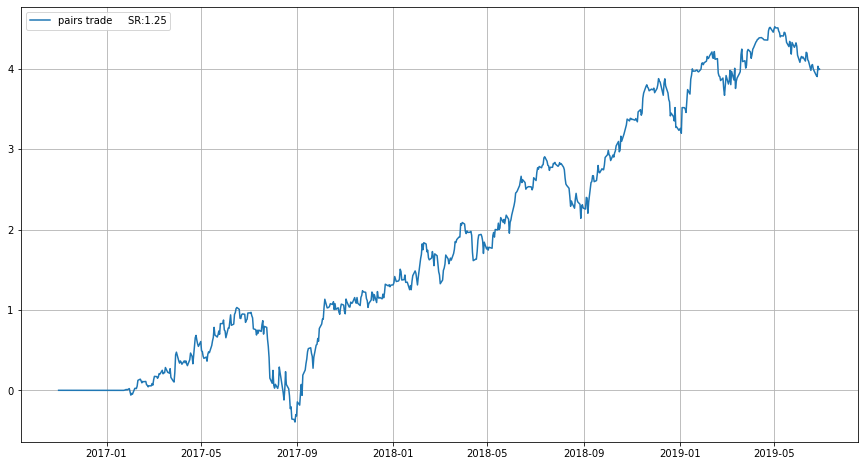

In [8]:
"""plot the total pairs strategy"""
pairs_pnl = pd.Series(pairs_pnl,index=base.index)

return_pairs_pnl = np.array((pairs_pnl+17).diff(1)[1:])/np.array((pairs_pnl[:-1]+17))
sharpe_ratio_pairs = return_pairs_pnl.mean()/return_pairs_pnl.std()*np.sqrt(252)

pairs_pnl.index = pd.to_datetime(pairs_pnl.index)

plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,2)))
# pairs_pnl.plot(label='pairs')
plt.legend()
plt.show()

In [9]:
pairs_pnl_pct=(pairs_pnl).pct_change()
pairs_pnl_pct=pairs_pnl_pct.replace([np.inf, -np.inf], np.nan)
pairs_pnl_pct=pairs_pnl_pct.fillna(0)

### carry trade

In [10]:
class Portfolio:
    def __init__(self,length):
        self.long=[[10,0,0],[10,0,0]] #currency index, open price, quantity, 10 represents closed position
        self.short=[[10,0,0],[10,0,0]]
        self.long_history=np.zeros((length,10))    #the history of position
        self.short_history=np.zeros((length,10)) 
        self.value=0
        self.value_track=[0]
        self.returns=[]
        self.status="closed"
    def reset_longshort(self):
        self.long=[[10,0,0],[10,0,0]] 
        self.short=[[10,0,0],[10,0,0]]
        self.status="closed"

def get_rate(s,row_n):  #get excess rate
    return np.array([np.log(s[i].iloc[row_n,1]) for i in range(10)])

def gen_portfolio(s, f): #s:spot rate; f:one month forward rate
    p1,p2,p3,p4,p5=[],[],[],[],[]
    length=len(s[0])
    for d in range(length):
        spot_list=[]
        forward_list=[]
        for cur in range(10):
            spot_list.append(s[cur].iat[d,1])
            forward_list.append(f[cur].iat[d,1])
        forward_premium=list(map(sub,np.log(forward_list),np.log(spot_list)))
        forward_premium_sort=np.argsort(forward_premium)
        p5.append([forward_premium_sort[0],forward_premium_sort[1]])
        p4.append([forward_premium_sort[2],forward_premium_sort[3]])
        p3.append([forward_premium_sort[4],forward_premium_sort[5]])
        p2.append([forward_premium_sort[6],forward_premium_sort[7]])
        p1.append([forward_premium_sort[8],forward_premium_sort[9]])
        p=(p1,p2,p3,p4,p5)
    return p

def cal_mv(s,f,D=21):   #calculate mv
    mv=[]
    length=len(s[0])
    m=s[0].iat[0,0].month
    mv_n=0
    for d in range(2,length):
        if s[0].iat[d,0].month!=m:
            mv.append(mv_n)
            mv_n=0
        r=get_rate(s,d)-get_rate(f,d-1)
        r_lag=get_rate(s,d-1)-get_rate(f,d-2)
        mv_n+=sum(r**2+2*r*r_lag)/100
        m=s[0].iat[d,0].month
    return mv

def close_pos(port,d,s,f,p1,p5): #return value brought by closing position
    long_value=s[port.long[0][0]].iat[d,1]*port.long[0][2]+s[port.long[1][0]].iat[d,1]*port.long[1][2]
    short_value=s[port.short[0][0]].iat[d,1]*port.short[0][2]+s[port.short[1][0]].iat[d,1]*port.short[1][2]
    port.long_history[d,port.long[0][0]]-=port.long[0][2]
    port.long_history[d,port.long[1][0]]-=port.long[1][2]
    port.short_history[d,port.short[0][0]]-=port.short[0][2]
    port.short_history[d,port.short[1][0]]-=port.short[1][2]
    port.value=long_value+short_value
    port.value_track.append(port.value)
    if (port.value_track[-2])!=0:
        port.returns.append(port.value_track[-1]/port.value_track[-2]-1)
    port.reset_longshort()
    return port
    
def open_pos(port,d,s,f,p1,p5): #opening position
    port.long=[[p1[d][0],s[p1[d][0]].iat[d,1],1/4/s[p1[d][0]].iat[d,1]],[p1[d][1],s[p1[d][1]].iat[d,1],1/4/s[p1[d][1]].iat[d,1]]]
    port.short=[[p5[d][0],s[p5[d][0]].iat[d,1],-1/4/s[p5[d][0]].iat[d,1]],[p5[d][1],s[p5[d][1]].iat[d,1],-1/4/s[p5[d][1]].iat[d,1]]]
    port.long_history[d,p1[d][0]]+=1/4/s[p1[d][0]].iat[d,1]    #record position
    port.long_history[d,p1[d][1]]+=1/4/s[p1[d][1]].iat[d,1]
    port.short_history[d,p5[d][0]]-=1/4/s[p5[d][0]].iat[d,1]
    port.short_history[d,p5[d][1]]-=1/4/s[p5[d][1]].iat[d,1]
    port.status="open"
    return port
    
def t_strategy(t,s,f,mv,p): #inplement t strategy
    p1,p2,p3,p4,p5=p
    length=len(s[0])
    port=Portfolio(length)
    port=open_pos(port,0,s,f,p1,p5)    
    d=0
    m=0
    while m<11:
        d+=1
        if s[0].iat[d,0].month!=s[0].iat[d-1,0].month:
            m+=1
            if port.status=="open":
                port=close_pos(port,d,s,f,p1,p5)
                port=open_pos(port,d,s,f,p1,p5)
    while d<length-2:
        d+=1
        if s[0].iat[d,0].month!=s[0].iat[d-1,0].month:
            m+=1
            t_indicator_1=port.returns[-1]<np.percentile(port.returns,t)
            t_indicator_2=mv[m-1]>np.percentile(mv[:m-1],50)
            t_indicator=(t_indicator_1 and t_indicator_2)   #critical indicators (t quantile and mv), please refer to the summary paper
            if (t_indicator and (port.status=="open")):
                port=close_pos(port,d,s,f,p1,p5)
            elif ((not t_indicator) and (port.status=="open")):
                port=close_pos(port,d,s,f,p1,p5)
                port=open_pos(port,d,s,f,p1,p5)
            elif ((not t_indicator) and (port.status=="closed")):
                port.value_track.append(0)
                port=open_pos(port,d,s,f,p1,p5)
            elif (t_indicator and (port.status=="closed")):
                port.value_track.append(0)
    if port.status=="open":
        d+=1
        port=close_pos(port,d,s,f,p1,p5)
    return port

def import_pd(cur):     #import spot and forward rate
    s=[]
    f=[]
    imp=pd.read_csv("forward_rate.csv")
    for i in range(10):
        fn=imp[["DATE",cur[i]]].copy(deep=True)
        fn["DATE"]=pd.to_datetime(fn["DATE"])
        f.append(fn)
    imp=pd.read_csv("fair_price.csv")
    for i in range(10):
        sn=imp[["DATE",cur[i]]].copy(deep=True)
        sn["DATE"]=pd.to_datetime(sn["DATE"])
        s.append(sn)
    return s,f

def output_pos(port,s,cur):     #ouput position information
    history_sum=port.long_history+port.short_history
    history_sum=pd.DataFrame(history_sum,index=s[0]["DATE"],columns=cur)
    history_sum.to_csv("t-quantile.csv")   #unquote to output position information 
    return history_sum

def plot_pos(history_sum,s):    #plotting
    s_sum=s[0]
    for i in range(1,10):
        s_sum[s[i].columns.values.tolist()[1]]=s[i].iloc[:,1]
    s_sum=s_sum.set_index(["DATE"])
    total_cf=history_sum*-s_sum
    total_cf_allq=total_cf.sum(axis=1)
    total_cf_allq=total_cf_allq.cumsum()
    total_cf_allq += 1
    plt.plot(total_cf_allq-1,label="monthly evaluated")
    return total_cf_allq

def cal_sharpe(history_sum,total_cf_allq,s):        #calculate sharpe ratio and plot daily values
    s_sum=s[0]
    for i in range(1,10):
        s_sum[s[i].columns.values.tolist()[1]]=s[i].iloc[:,1]
    s_sum=s_sum.set_index(["DATE"])
    history_cumsum=history_sum.cumsum()
    mark_to_market=history_cumsum*s_sum
    mark_to_market=mark_to_market.sum(axis=1)
    mark_to_market=mark_to_market+total_cf_allq
    plt.plot(mark_to_market-1,label="daily evaluated")
    mark_to_market=mark_to_market+1
    mark_to_market=mark_to_market.pct_change()[1:]
    return mark_to_market.mean()/mark_to_market.std()*np.sqrt(252)

sharpe ratio: 0.599627475451073


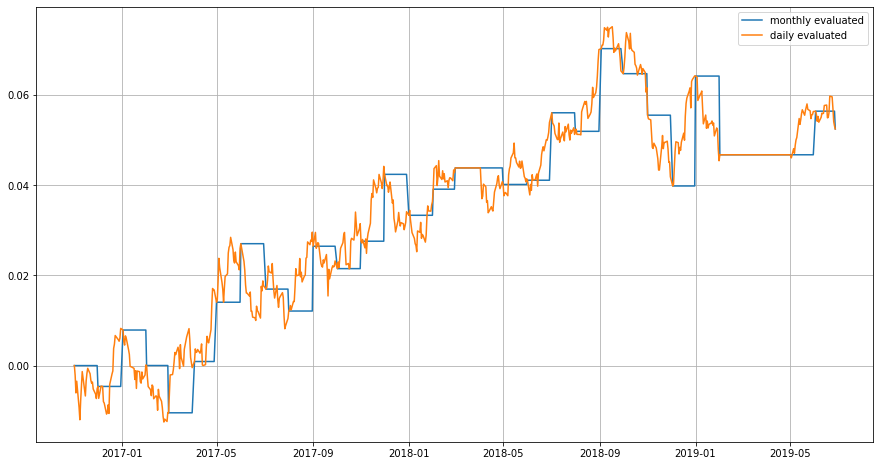

In [11]:
cur=['EUR', 'GBP', 'JPY', 'AUD', 'NZD', 'CAD', 'CHF', 'NOK', 'SEK', 'DKK']
s,f=import_pd(cur)
p=gen_portfolio(s, f)
mv=cal_mv(s,f)
t=50
'''for iterating t
for ti in range(5,6):
    t=10*ti #set threshold
    #for i in range(10):
    #    plt.plot(np.subtract(np.log(f[i].iloc[:,1]),np.log(s[i].iloc[:,1])))
    port=t_strategy(t,s,f,mv,p)
    #plt.plot(port.value_track[1:])
    pnl = np.array(port.value_track)
    pnl = pnl.cumsum()
    #plt.plot(pnl,label=t)
    #sharpe=np.mean(port.value_track)/np.std(port.value_track)*np.sqrt(12)
    #print("sharpe: " + str(t) + " " + str(sharpe))
#plt.legend()
#plt.show()
'''
port=t_strategy(t,s,f,mv,p)
pnl = np.array(port.value_track)
pnl = pnl.cumsum()
history_sum=output_pos(port,s,cur)
total_cf_allq=plot_pos(history_sum,s)
print("sharpe ratio: "+str(cal_sharpe(history_sum,total_cf_allq,s)))
plt.legend()
plt.show()

### combined strategy

In [12]:
t_strategy = history_sum
t_strategy_value_signal = t_strategy.cumsum()

t_strategy_money = t_strategy*-Data_sheet
t_strategy_money = t_strategy_money.sum(axis=1)-abs(t_strategy*Data_sheet*TRANS_FEE).sum(axis=1)
t_strategy_money = t_strategy_money.cumsum()

t_strategy_valule = t_strategy_value_signal*Data_sheet
t_strategy_valule = t_strategy_valule.sum(axis=1)

t_strategy_pnl = t_strategy_money+t_strategy_valule

t_strategy_pnl_pct=(t_strategy_pnl+1).pct_change()
t_strategy_pnl_pct=t_strategy_pnl_pct.replace([np.inf, -np.inf], np.nan)
t_strategy_pnl_pct=t_strategy_pnl_pct.fillna(0)

t_strategy_pnl.index = pd.to_datetime(t_strategy_pnl.index)
# t_strategy_pnl.plot(label='t-strategy')
# plt.legend()
# plt.show()


In [13]:
"""combine two strategy """
money_signal = signal
value_signal = money_signal.cumsum()

combine_money_signal = money_signal+t_strategy #money is when you close the position what you earn from that
combine_value_signal = value_signal+t_strategy.cumsum() #value is that you hold a position, if the price change, the value of your protofilio will change

money_pnl = combine_money_signal*-Data_sheet
money_pnl = money_pnl.sum(axis=1)-abs(combine_money_signal*Data_sheet*TRANS_FEE).sum(axis=1)
money_pnl = money_pnl.cumsum()

value_pnl = combine_value_signal*Data_sheet
value_pnl = value_pnl.sum(axis=1)


Combined_pnl = money_pnl+value_pnl
Combined_pnl_pct=(Combined_pnl+1).pct_change()
Combined_pnl_pct=Combined_pnl_pct.replace([np.inf, -np.inf], np.nan)
Combined_pnl_pct=Combined_pnl_pct.fillna(0)


Combined_pnl.index = pd.to_datetime(Combined_pnl.index)

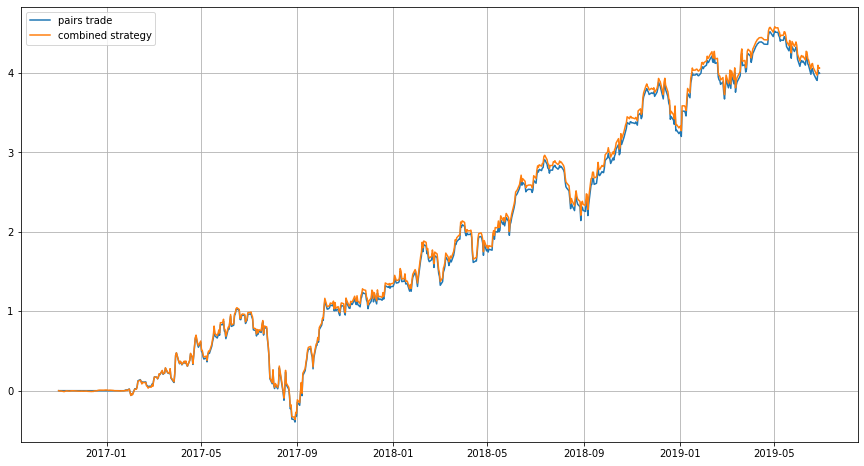

In [14]:
# plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,2)))
plt.plot(pairs_pnl,label='pairs trade')
# plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl_pct.mean()/Combined_pnl_pct.std()*np.sqrt(252),2)))
plt.plot(Combined_pnl,label = 'combined strategy')
plt.plot()
plt.legend()
plt.show()

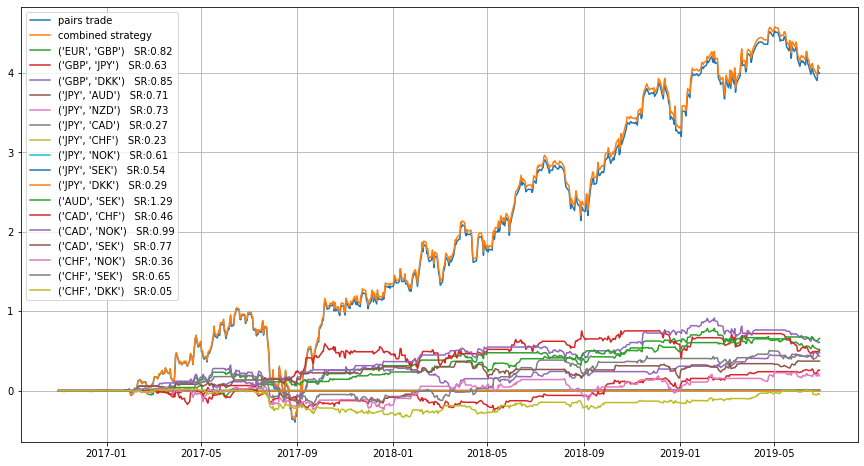

In [15]:
# plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,2)))
plt.plot(pairs_pnl,label='pairs trade')
# plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl_pct.mean()/Combined_pnl_pct.std()*np.sqrt(252),2)))
plt.plot(Combined_pnl,label = 'combined strategy')


pnl_series=[]
sharpe_series={}
pairs_pnl=[0]*N
signal = pd.DataFrame([[0]*10 for _ in range(N)],index=base.index,columns=namelist)

# polt the whole pairs
for i in range(len(pairs)):
    indexS1 = namelist.index(pairs[i][0])
    indexS2 = namelist.index(pairs[i][1])
    pnl,temp = trade(Data_sheet[pairs[i][0]].iloc[:N],
                     Data_sheet[pairs[i][1]].iloc[:N],indexS1,indexS2,5, 60)
    signal += temp
    pairs_pnl=list(map(lambda x,y:x+y,pnl,pairs_pnl))
    pnl.index = pd.to_datetime(pnl.index)

#     return_pnl = pnl.diff(1)/pnl
    return_pnl = np.array((pnl+1).diff(1)[1:])/np.array((pnl[:-1]+1))
    sharpe_ratio = return_pnl.mean()/return_pnl.std()*np.sqrt(252)
    pnl_series.append(return_pnl)
    sharpe_series[pairs[i]]=sharpe_ratio
#     pnl.plot(label=pairs[i])
    plt.plot(pnl,label=str(pairs[i])+'   SR:'+str(round(sharpe_ratio,2)))

plt.legend()
plt.show()

In [16]:
"""sharpe ratio"""
# print ("Transaction Fee: %.4f" %TRANS_FEE)
print ("PairsTrade return: %.4f, PairsTrade sharpe ratio: %.4f" %(pairs_pnl[-1],sharpe_ratio_pairs)) #pairs_pnl_pct.mean()/pairs_pnl_pct.std()*np.sqrt(252)))
print ("CarryTrade return: %.4f, CarryTrade sharpe ratio: %.4f" %(t_strategy_pnl[-1],t_strategy_pnl_pct.mean()/t_strategy_pnl_pct.std()*np.sqrt(252)))
print ("CombinedStrategy return: %.4f, CombinedStrategy sharpe ratio: %.4f" %(Combined_pnl[-1],Combined_pnl_pct.mean()/Combined_pnl_pct.std()*np.sqrt(252)))

PairsTrade return: 3.9954, PairsTrade sharpe ratio: 1.2485
CarryTrade return: 0.0504, CarryTrade sharpe ratio: 0.5863
CombinedStrategy return: 4.0605, CombinedStrategy sharpe ratio: 1.2394


In [17]:
"""output position,pnl"""
strategy_net_val = pd.concat([pairs_pnl,t_strategy_pnl,Combined_pnl],axis=1)
strategy_net_val.columns = ['pair_trading','t_strategy','combined']
strategy_net_val.to_csv("strategy_net_value.csv")
combine_value_signal.to_csv("position_daily.csv")

TypeError: cannot concatenate object of type "<class 'list'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid